In [1]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import numpy as np

In [2]:
dataset_id = 1

In [3]:
dataset_name = "glass" if dataset_id == 0 else "sat_image"
results_dir = os.path.join(os.getcwd(), f"results_{dataset_name}")
results_file = os.path.join(results_dir, "results.json")

In [4]:
plot_dir = os.path.join(results_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)

In [5]:
data_results = json.load(open(results_file, "r"))

In [6]:

from matplotlib.ticker import FuncFormatter, LogLocator


def extract_step(step_key):
    """Extract numeric value from 'block:{step}'."""
    return int(re.search(r"block:(\d+)", step_key).group(1))

def average_metrics_over_seeds(data):
    # Collect per metric and model
    temp = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # metric -> model -> step -> list of values

    for seed_data in data.values():
        for model, metrics in seed_data.items():
            for metric, steps in metrics.items():
                for step_key, value in steps.items():
                    step = extract_step(step_key)
                    temp[metric][model][step].append(value)

    # Average across seeds
    averaged = defaultdict(lambda: defaultdict(dict))
    for metric, models in temp.items():
        for model, steps in models.items():
            for step, values in steps.items():
                if metric == "confusion_matrix":
                    # For confusion matrix, we average the individual matrices
                    averaged[metric][model][step] = np.mean(values, axis=0).tolist()
                else:
                    averaged[metric][model][step] = np.sum(values) / len(values)

    return averaged

def plot_metrics(data, lines_dict=None, color_dict=None, plots_dir=None, dataset_name=None, name_map=None):
    averaged = average_metrics_over_seeds(data)
    json.dump(averaged, open(os.path.join(plots_dir, "averaged_results.json"), "w"), indent=4)

    for metric, models in averaged.items():
        if metric == "confusion_matrix" or metric == "retrainings":
            continue
        fig= plt.figure(figsize=(8, 5))
        x = None
        for model, steps in models.items():
            sorted_steps = sorted(steps.items())
            if x is None:
                x = [s[0] for s in sorted_steps]
            y = [s[1] for s in sorted_steps]
            plt.plot(x, y, label=name_map[model], marker='o', linestyle=lines_dict[model], markersize=3, color=color_dict[model])

        #plt.xticks(range(len(x)), x, rotation=45)
        d_name = "Statlog" if dataset_name == "sat_image" else "Glass"
        title = f"{metric} across models{f' on dataset {d_name}' if dataset_name is not None else ''}"
        title = title.replace("_", " ")
        title = title.title()
        plt.title(title)
        plt.xlabel("Training samples per class")
        plt.xscale('log')
        if max(x) > 100:
            plt.gca().xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: ''))
        else:
            plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
            plt.gca().xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
        plt.xlim(left=1, right=max(x))
        y_label = metric.replace("_", " ").title()
        if "time" in metric:
            y_label += " [s]"
        else:
            y_label += " [a.u.]"
        plt.ylabel(y_label)
        plt.legend()
        plt.grid(True)
        plt.grid(which='both', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        if plots_dir is not None:
            fig.savefig(os.path.join(plots_dir, f"{dataset_name}_{metric}_plot.pdf"), dpi=300, bbox_inches='tight', format='pdf')
# Example usage
# plot_metrics(your_data_dict)


In [7]:
lines_dict = {
    'rf': "-",
    'rf_mislead': "-",
    'iso + rf': "-",
    'rf_self': "-.",
    'rf_self09': "-.",
    'flexc_labels': "--",
    'flexc_centroids': "--",
    'flexc_centroids_v2': "--"
}
color_dict = {
    'rf': "#d83034",
    'rf_mislead': "#003a7d",
    'iso + rf': "#3fa271",
    'rf_self': "#ff73b6",
    'rf_self09': "#e1d834",  
    'flexc_labels': "#5ecaba",
    'flexc_centroids': "#cf23ff",
    'flexc_centroids_v2': "#935610",
    }
name_map = {
    'flexc_centroids_v2': 'FLEX-C Centroid v2',
    'flexc_centroids': 'FLEX-C Centroid',
    'rf_self': 'RF Naive Self',
    'rf_self09': 'RF Self C=0.9',
    'rf_mislead': 'RF Mislead',
    'rf': 'RF',
    'iso + rf': 'Cascade',
    'flexc_labels': 'FLEX-C Label'
}

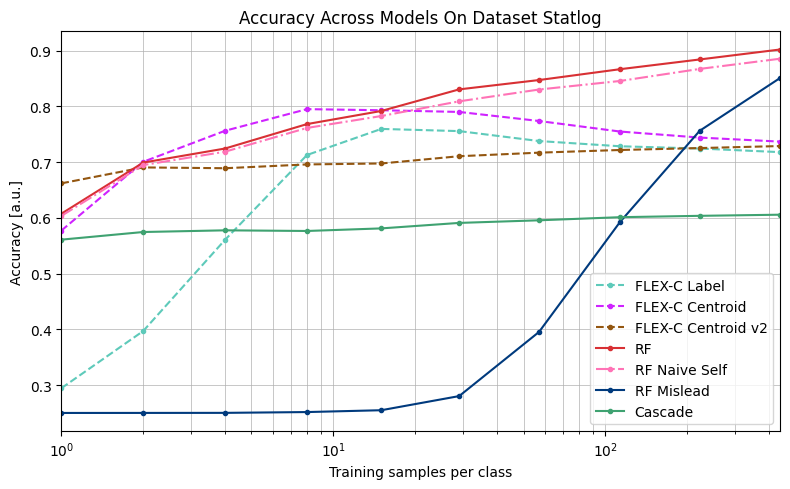

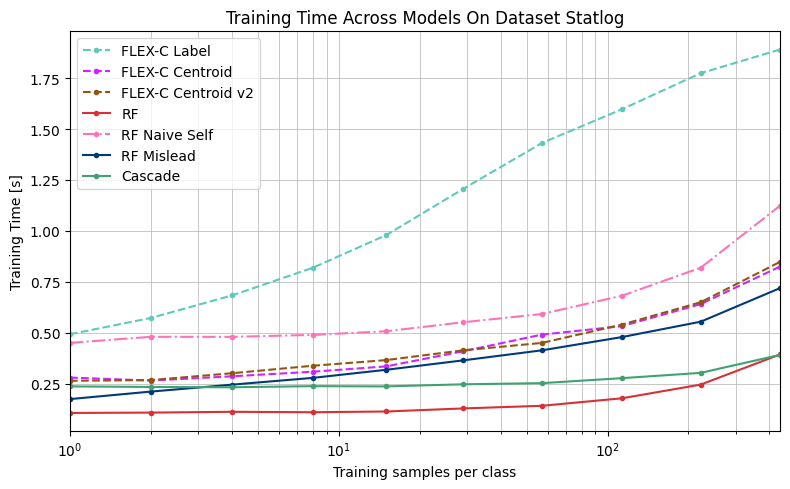

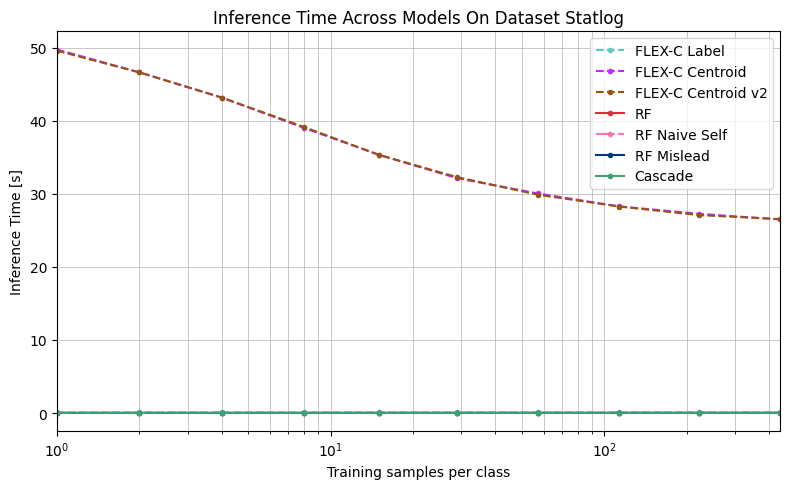

In [8]:
plot_metrics(data_results, lines_dict=lines_dict, color_dict=color_dict, plots_dir=plot_dir, dataset_name=dataset_name, name_map=name_map)